<a href="https://colab.research.google.com/github/RJAbuNasser/Final-Project/blob/main/Playing_w_the_assig_fixed_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-posthocs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro, wilcoxon, friedmanchisquare
import scikit_posthocs as sp
import zipfile

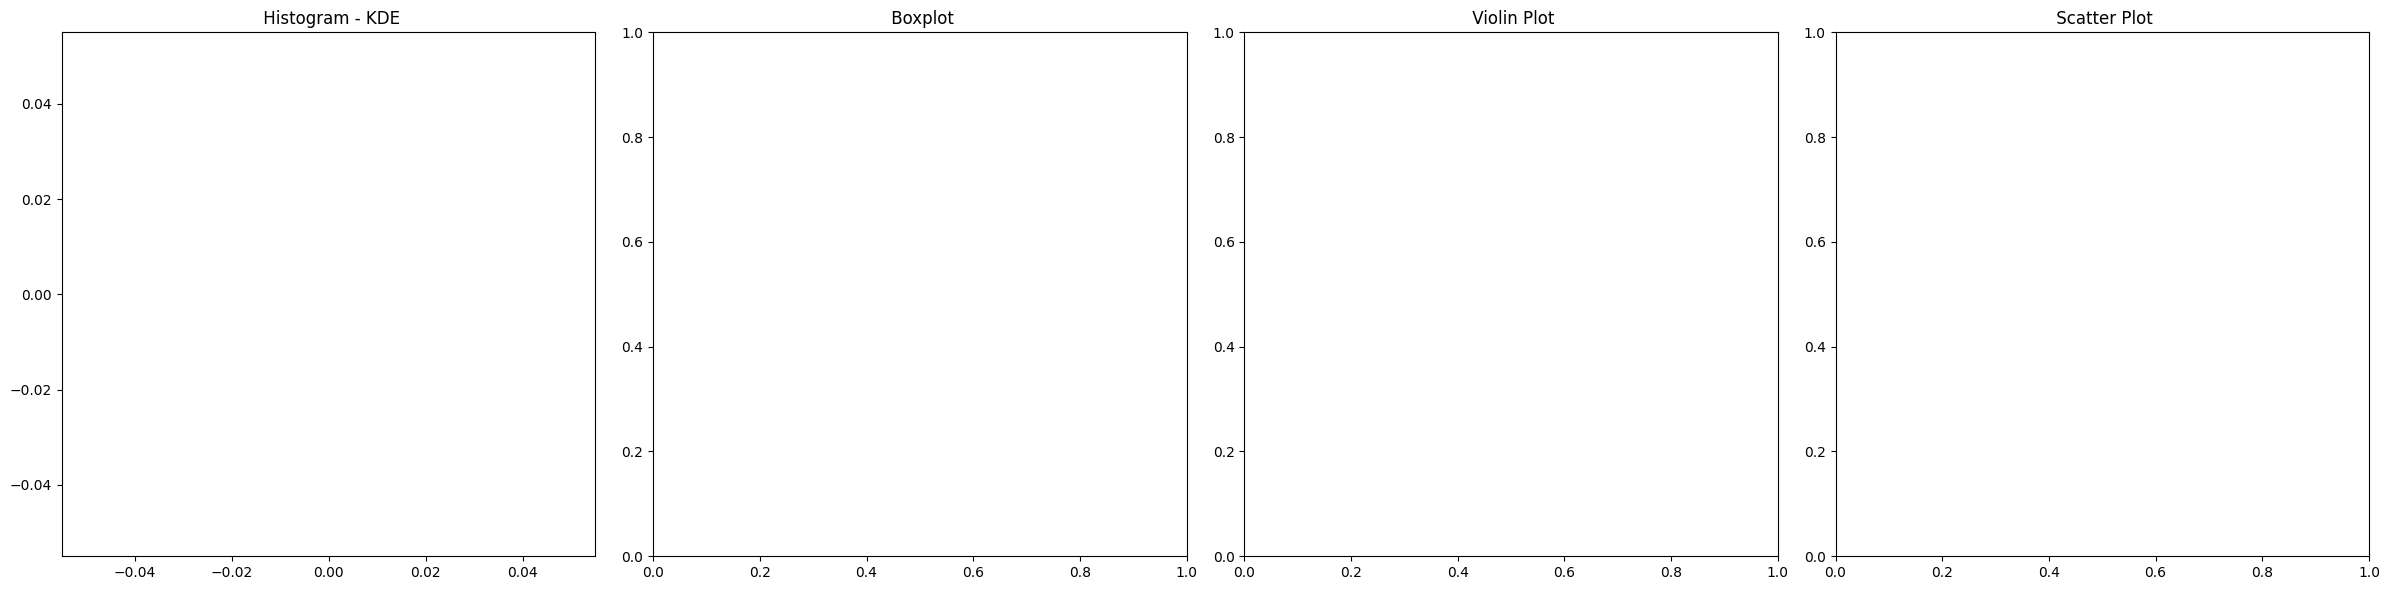

(<Figure size 2400x600 with 4 Axes>,
 array([<Axes: title={'center': ' Histogram - KDE'}>,
        <Axes: title={'center': ' Boxplot'}>,
        <Axes: title={'center': ' Violin Plot'}>,
        <Axes: title={'center': ' Scatter Plot'}>], dtype=object))

In [29]:

title_prefix = ''

def plot_data(data, title_prefix):
    title_prefix = title_prefix
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    sns.histplot(data, bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f'{title_prefix} Histogram - KDE')
    sns.boxplot(data=data, ax=axes[1])
    axes[1].set_title(f'{title_prefix} Boxplot')
    sns.violinplot(data=data, ax=axes[2])
    axes[2].set_title(f'{title_prefix} Violin Plot')
    sns.scatterplot(x=range(len(data)), y=data, ax=axes[3])
    axes[3].set_title(f'{title_prefix} Scatter Plot')
    plt.tight_layout()
    plt.show()
    return fig, axes


combined_dict = {**data_storage, **exl_read}
plot_data(combined_dict,title_prefix)



In [5]:

def test_normality(data):
    results = {}
    for group, values in data.items():
        if len(values) >= 3:
            stat, p_value = shapiro(values)
            results[group] = p_value > 0.05
        else:
            results[group] = None
    return results


In [6]:
def ttest(data, reference):
    results = {}
    for group, values in data.items():
        if group != reference and len(data[reference]) == len(values):
            stat, p_value = ttest_ind(data[reference], values)
            results[group] = p_value
    return results

In [7]:
def perform_wilcoxon(data, reference):
    results = {}
    for group, values in data.items():
        if group != reference and len(data[reference]) == len(values):
            stat, p_value = wilcoxon(data[reference], values)
            results[group] = p_value
    return results

In [8]:
def perform_friedman(data):
    values = [data[group] for group in data]
    stat, p_value = friedmanchisquare(*values)
    return stat, p_value

In [9]:
def post_hoc_analysis(data, alpha=0.05):
    groups = list(data.keys())
    data_array = np.array([data[group] for group in groups]).T
    bonferroni = sp.posthoc_dunn(data_array, p_adjust='bonferroni')
    holm = sp.posthoc_dunn(data_array, p_adjust='holm')
    holland = sp.posthoc_dunn(data_array, p_adjust='holland')
    hochberg = sp.posthoc_dunn(data_array, p_adjust='hochberg')
    hommel = sp.posthoc_dunn(data_array, p_adjust='hommel')
    return {
        'Bonferroni': bonferroni,
        'Holm': holm,
        'Holland': holland,
        'Hochberg': hochberg,
        'Hommel': hommel
    }

In [30]:
def process_txt(file, actual_file, algorithm_folder):
    data = np.loadtxt(file, delimiter=' ')
    actual = np.loadtxt(actual_file, delimiter=' ')
    merrors = data - actual
    return {algorithm_folder: merrors.tolist()}



dict

In [23]:
'''
1st try
'''
data_storage = {}

def process_txt(file, actual_file, algorithm_folder):
    global data_storage
    data = np.loadtxt(file, delimiter=' ')
    actual = np.loadtxt(actual_file, delimiter=' ')
    merrors = data - actual
    data_storage[algorithm_folder] = data   #Store data in global data_storage for later use
    return {algorithm_folder: merrors.tolist()}



In [14]:
def process_xlsx(file, actual_file, algorithm_folder):
    df = pd.read_excel(file, sheet_name=None)
    actual = pd.read_excel(actual_file, sheet_name=None)
    merrors = {}
    for sheet_name, sheet_df in df.items():
        actual_sheet = actual[sheet_name]
        merrors[sheet_name] = (sheet_df.iloc[:, 1] - actual_sheet.iloc[:, 1]).tolist()
    return {f"{algorithm_folder}_{sheet_name}": value for sheet_name, value in merrors.items()}

In [24]:
'''
1st try
'''
exl_read={}
def process_xlsx(file, actual_file, algorithm_folder):
    global exl_read
    df = pd.read_excel(file, sheet_name=None)
    actual = pd.read_excel(actual_file, sheet_name=None)
    merrors = {}
    for sheet_name, sheet_df in df.items():
        actual_sheet = actual[sheet_name]
        merrors[sheet_name] = (sheet_df.iloc[:, 1] - actual_sheet.iloc[:, 1]).tolist()
        exl_read[algorithm_folder] = df#Store read data in global exl_read for later use
    return {f"{algorithm_folder}_{sheet_name}": value for sheet_name, value in merrors.items()}





In [25]:
def analyze_grouped_data(data, reference_group, output_file_prefix, use_summary_files=False):
    if use_summary_files:
        summary_file = f"{output_file_prefix}_Summary.xlsx"
        summary_df = pd.read_excel(summary_file)
        summarized_data = {row['Group']: [row['Mean Error']] for index, row in summary_df.iterrows()}
    else:
        summarized_data = data

    summary = []
    for group, values in summarized_data.items():
        summary.append({
            "Group": group,
            "Mean Error": np.mean(values),
            "Std Dev": np.std(values),
            "Normality": test_normality({group: values})[group]
        })

    ttest_results = ttest(summarized_data, reference_group)
    friedman_stat, friedman_p = perform_friedman(summarized_data)
    wilcoxon_results = perform_wilcoxon(summarized_data, reference_group)
    post_hoc_results = post_hoc_analysis(summarized_data)

    summary_df = pd.DataFrame(summary)
    summary_df.to_excel(f"{output_file_prefix}_Summary.xlsx", index=False)
    print(f"Summary saved to {output_file_prefix}_Summary.xlsx")

    for method, results_df in post_hoc_results.items():
        results_df.to_excel(f"{output_file_prefix}_PostHoc_{method}.xlsx", index=True)
        print(f"Post-hoc results ({method}) saved to {output_file_prefix}_PostHoc_{method}.xlsx")


In [31]:
def process_zip(data_zip_path, actual_values_zip_path, use_summary_files=False):
    with zipfile.ZipFile(data_zip_path, 'r') as data_zip, zipfile.ZipFile(actual_values_zip_path, 'r') as actual_zip:
        for folder in ["10-D", "20-D"]:
            files_by_folder = {file.split('/')[0]: [] for file in data_zip.namelist() if folder in file}
            for file in data_zip.namelist():
                if folder in file:
                    files_by_folder[file.split('/')[0]].append(file)
            for algorithm_folder, files in files_by_folder.items():
                reference_group = None
                for i, file in enumerate(files):
                    if file in data_zip.namelist() and file in actual_zip.namelist():
                        folder_name = file.split('/')[0]
                        if file.endswith('.txt'):
                            with data_zip.open(file) as f, actual_zip.open(file) as af:
                                data = process_txt(f, af, f"{algorithm_folder}_{folder}_{i}")
                        elif file.endswith('.xlsx'):
                            with data_zip.open(file) as f, actual_zip.open(file) as af:
                                data = process_xlsx(f, af, f"{algorithm_folder}_{folder}_{i}")

                        if i == 0:
                            reference_group = list(data.keys())[0]

                        output_file_prefix = f"{algorithm_folder}_{folder}_Analysis_{i}"
                        analyze_grouped_data(data, reference_group, output_file_prefix, use_summary_files)

In [32]:
process_zip("Data-All Algos.zip", "Actual Values.zip", use_summary_files=True)
